In [40]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ML model and preprocessing imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

# Fine-tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score

# Pipeline imports
from sklearn.pipeline import Pipeline, make_pipeline

# External libraries
import xgboost as xgb

# Local imports
from preprocessing_ML import get_features_and_target

# Getting data

In [3]:
df = get_features_and_target(
    "BTC/USDT", steps_to_forecast=1, model_freq="1d", feature_lags=[]
)

X = df.drop(columns="BTC:USDT_target")
y = df["BTC:USDT_target"].copy()

split_index = int(len(X) * 0.85)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1812, 14), (320, 14), (1812,), (320,))

# Distributins after transformation 


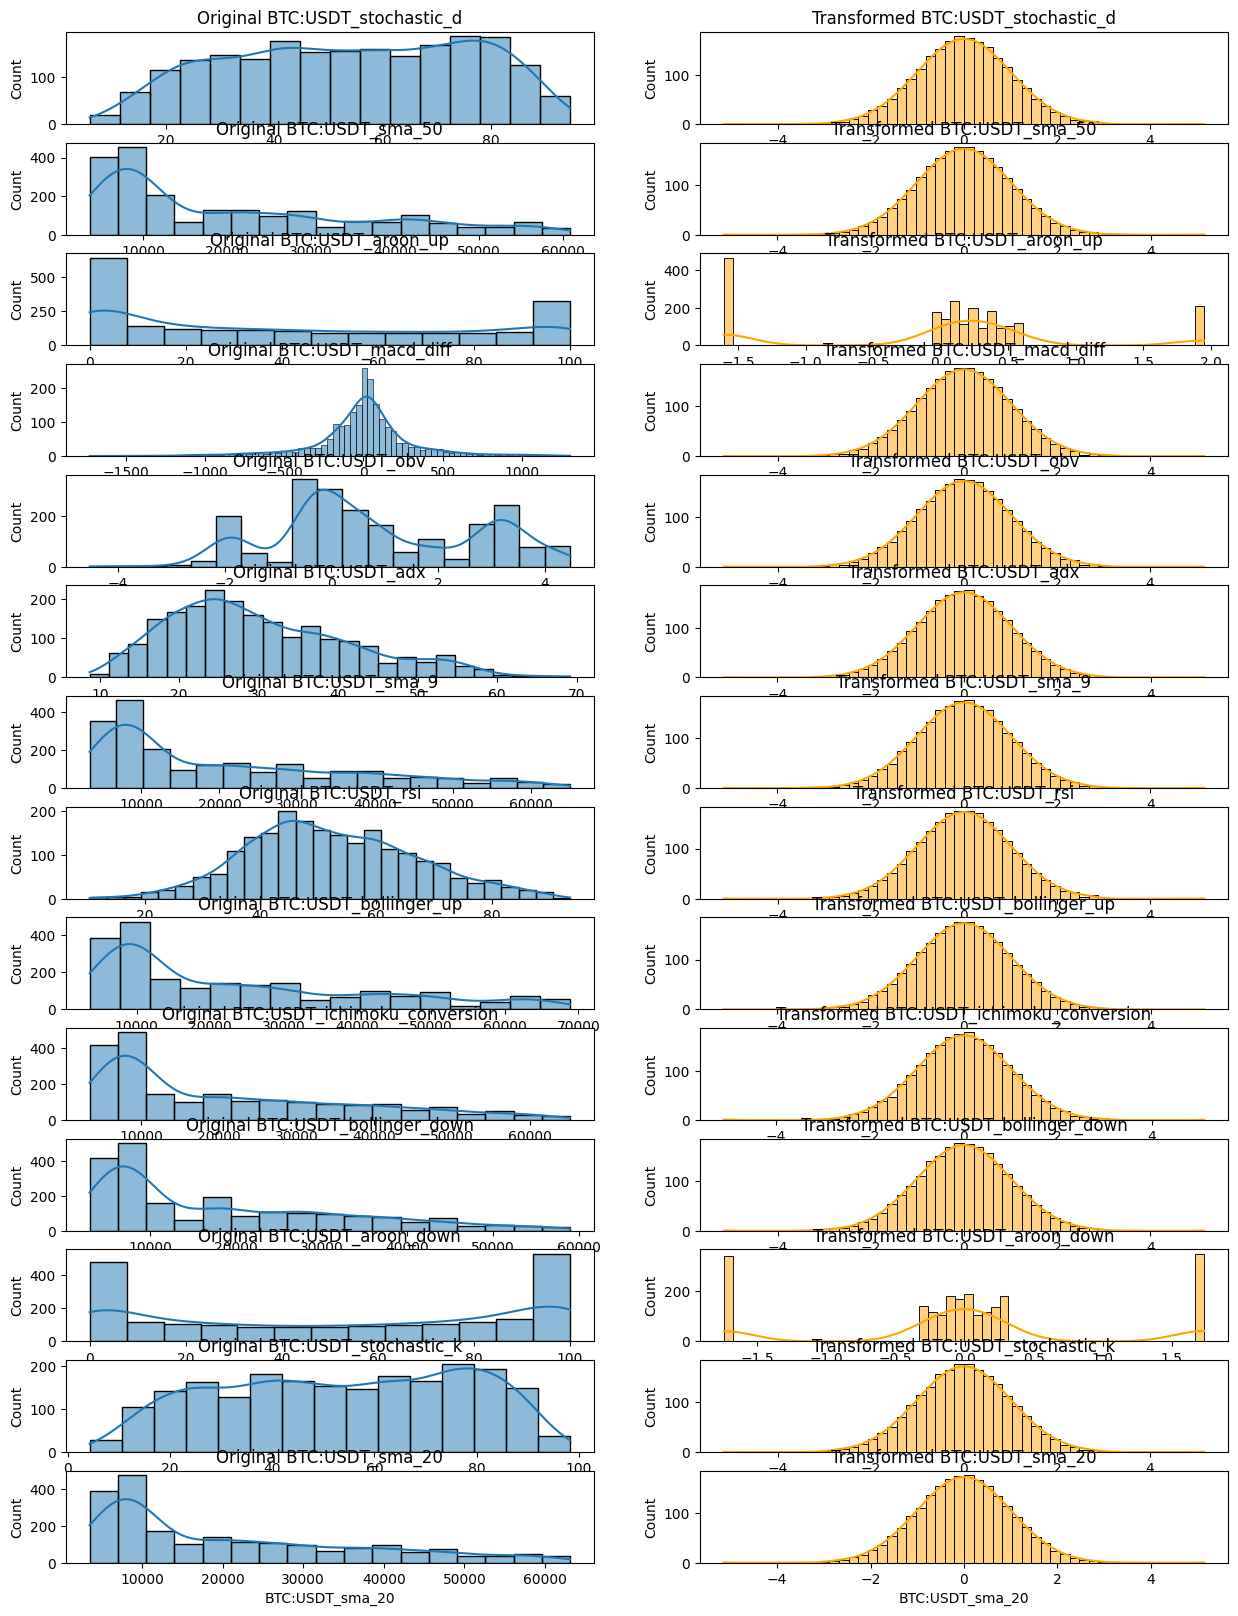

In [9]:
# Apply Quantile Transformer
transform_pipe = Pipeline(
    [
        (
            "Normilizer",
            QuantileTransformer(
                output_distribution="normal", random_state=99, n_quantiles=300
            ),
        ),
        ("Scaler", StandardScaler()),
    ]
)
X_transformed = transform_pipe.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=X.columns)

# Select 20 random columns (same as before)
num_cols = min(len(X.columns), 20)
random_columns = np.random.choice(X.columns, num_cols, replace=False)

# Set up the matplotlib figure (2 rows for each column: before and after)
plt.figure(figsize=(15, 2 * 20))  # Adjust the size as needed

# Plot each histogram before and after transformation
for i, col in enumerate(random_columns):
    # Original Data
    plt.subplot(2 * num_cols, 2, 2 * i + 1)  # 2*num_cols rows, 2 columns per row
    sns.histplot(X[col], kde=True)
    plt.title(f"Original {col}")
    # plt.tight_layout()

    # Transformed Data
    plt.subplot(2 * num_cols, 2, 2 * i + 2)
    sns.histplot(X_transformed[col], kde=True, color="orange")
    plt.title(f"Transformed {col}")
    # plt.tight_layout()

plt.show()

In [10]:
X_transformed

,BTC:USDT_sma_9,BTC:USDT_sma_20,BTC:USDT_sma_50,BTC:USDT_rsi,BTC:USDT_bollinger_up,BTC:USDT_bollinger_down,BTC:USDT_adx,BTC:USDT_macd_diff,BTC:USDT_obv,BTC:USDT_ichimoku_conversion,BTC:USDT_stochastic_k,BTC:USDT_stochastic_d,BTC:USDT_aroon_up,BTC:USDT_aroon_down
0,-1.541845,-1.594507,-1.644120,0.251589,-1.601244,-1.708544,-0.227237,0.293452,-0.296602,-1.541569,-0.513626,-0.018155,-0.046659,0.131825
1,-1.538916,-1.587211,-1.643000,0.365016,-1.594715,-1.670073,-0.360798,0.273840,-0.294464,-1.537600,-0.531878,-0.447462,-1.607267,0.085738
2,-1.534716,-1.579615,-1.638822,0.445622,-1.589886,-1.616895,-0.536472,0.268308,-0.293209,-1.537600,0.172731,-0.281801,-1.607267,0.044153
3,-1.526921,-1.573330,-1.632240,0.780685,-1.579226,-1.642852,-0.657281,0.348990,-0.291026,-1.525019,0.925683,0.164828,-1.607267,1.733927
4,-1.520156,-1.564332,-1.623790,0.954819,-1.565871,-1.674523,-0.685120,0.408391,-0.288461,-1.512704,1.723558,0.847823,-1.607267,1.733927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,0.878996,0.879195,0.740782,0.616092,0.745291,1.023896,1.231360,-0.763391,-1.136277,0.876679,-0.019895,0.239361,-1.607267,0.085738
2128,0.881446,0.881542,0.745377,0.623874,0.750063,1.025240,1.183863,-0.708931,-1.125959,0.878928,-0.012214,0.034448,-1.607267,1.733927
2129,0.891159,0.882403,0.750157,0.544588,0.751736,1.024944,1.103018,-0.729440,-1.131575,0.878928,0.258273,0.083108,-1.607267,0.269667
2130,0.898933,0.885572,0.760367,0.864650,0.759384,1.019377,1.077838,-0.515864,-1.121744,0.910111,0.470914,0.281470,0.178406,1.733927


# Test of feature selection

In [11]:
# Example using RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
sfm = SelectFromModel(model)

# Assume X and y are your training data and labels
sfm.fit(X, y)

# To see the features selected
selected_features = sfm.get_support()
print("Selected features:", selected_features)

# To get the names of the selected features if you have a DataFrame
selected_feature_names = X.columns[selected_features]
print("Selected feature names:", selected_feature_names)

Selected features: [False False False  True False False  True  True  True False  True  True
 False False]
Selected feature names: Index(['BTC:USDT_rsi', 'BTC:USDT_adx', 'BTC:USDT_macd_diff', 'BTC:USDT_obv',
       'BTC:USDT_stochastic_k', 'BTC:USDT_stochastic_d'],
      dtype='object')


# Pipeline

In [34]:
# Preprocessing pipeline
preprocessing = make_pipeline(
    QuantileTransformer(output_distribution="normal", random_state=99, n_quantiles=300),
    StandardScaler(),
    SelectFromModel(RandomForestRegressor(random_state=99)),
)

# Define the pipelines for each model
pipelines = {
    "Random_Forest": Pipeline(
        [
            ("prep", preprocessing),
            ("model", RandomForestRegressor(random_state=99)),
        ]  # Winner
    ),
    "Gradient_Boosting": Pipeline(
        [("prep", preprocessing), ("model", GradientBoostingRegressor(random_state=99))]
    ),
    "K-Nearest_Neighbors": Pipeline(
        [("prep", preprocessing), ("model", KNeighborsRegressor())]
    ),
    "XGBoost": Pipeline(
        [
            ("prep", preprocessing),
            ("model", xgb.XGBRegressor(random_state=99)),
        ]  # Second place
    ),
}

# Testing of default models

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

scores = {}

for name, pipeline in pipelines.items():
    mse_scores = cross_val_score(
        pipeline, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1
    )
    mae_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )
    scores[f"{name}_MSE"] = -mse_scores  # Negate to get positive MSE values
    scores[f"{name}_MAE"] = -mae_scores  # Negate to get positive MAE values

<Figure size 1500x1500 with 0 Axes>

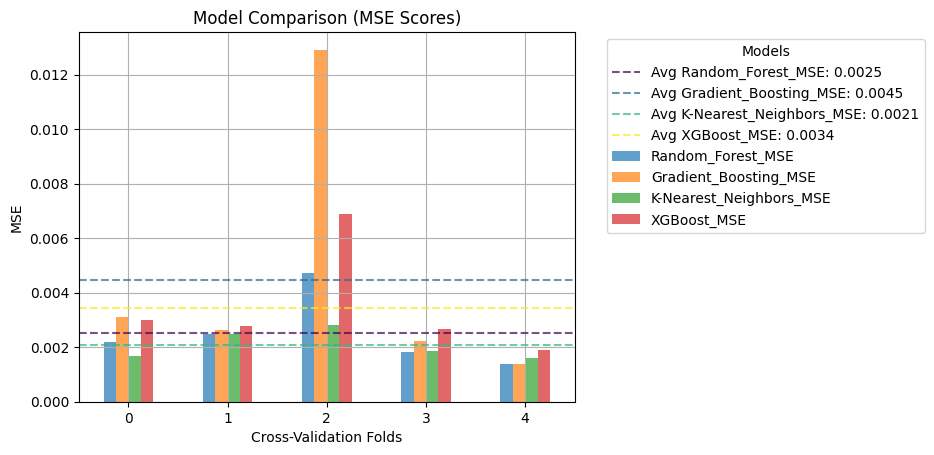

<Figure size 1500x1500 with 0 Axes>

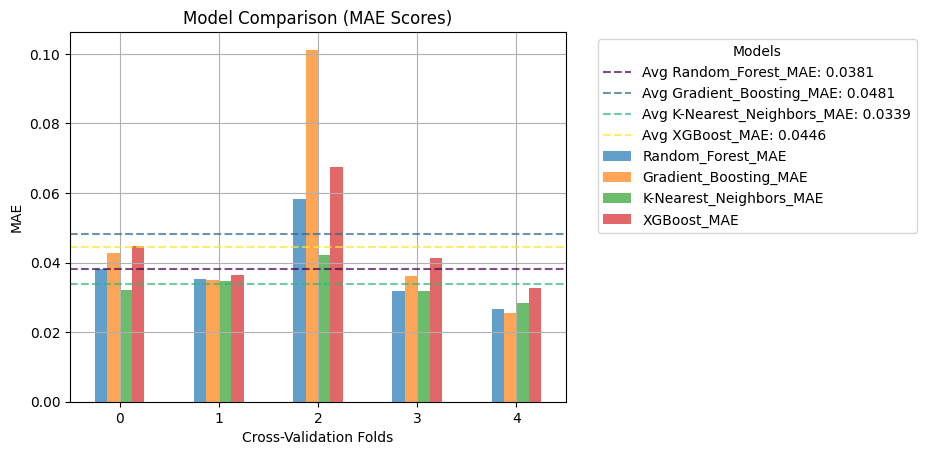

,Random_Forest_MSE,Random_Forest_MAE,Gradient_Boosting_MSE,Gradient_Boosting_MAE,K-Nearest_Neighbors_MSE,K-Nearest_Neighbors_MAE,XGBoost_MSE,XGBoost_MAE
0,0.002209,0.038223,0.003103,0.042903,0.001660,0.032236,0.002986,0.044843
1,0.002487,0.035229,0.002641,0.034940,0.002480,0.034707,0.002788,0.036577
2,0.004739,0.058280,0.012915,0.101214,0.002833,0.042103,0.006879,0.067544
3,0.001836,0.031971,0.002237,0.036082,0.001844,0.031944,0.002673,0.041243
4,0.001387,0.026666,0.001375,0.025600,0.001606,0.028414,0.001916,0.032670


In [36]:
scores_df = pd.DataFrame(scores)

for metric in ["MSE", "MAE"]:
    plt.figure(figsize=(15, 15))

    metric_scores = scores_df.filter(like=metric)

    ax = metric_scores.plot(kind="bar", alpha=0.7)

    averages = metric_scores.mean()
    colors = plt.cm.viridis(np.linspace(0, 1, len(averages)))
    for i, (average, color) in enumerate(zip(averages, colors)):
        plt.axhline(
            y=average,
            color=color,
            linestyle="--",
            alpha=0.7,
            label=f"Avg {metric_scores.columns[i]}: {average:.4f}",
        )

    plt.title(f"Model Comparison ({metric} Scores)")
    plt.ylabel(metric)
    plt.xlabel("Cross-Validation Folds")
    plt.xticks(rotation=0)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

scores_df

# Fine-tuning


In [41]:
RF_pipeline = pipelines["Random_Forest"]

KNN_pipeline = pipelines["K-Nearest_Neighbors"]

# Not fine-tuned RF and KNN metrics

In [42]:
RF_pipeline.fit(X_train, y_train)
KNN_pipeline.fit(X_train, y_train)

predictions_RF = RF_pipeline.predict(X_test)
predictions_KNN = KNN_pipeline.predict(X_test)

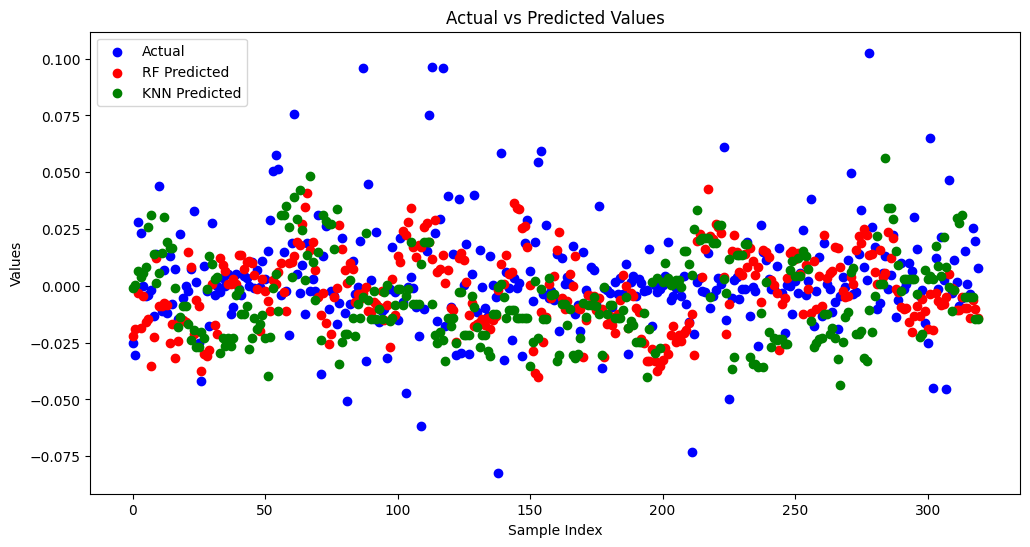

Random Forest Metrics:
Mean Absolute Error: 0.02089455332829378
Mean Absolute Percentage Error: 7.160237402323641
Mean Squared Error: 0.0007580609226380356
R2 Score: -0.4139779279237774

KNN Metrics:
Mean Absolute Error: 0.023780248672895944
Mean Absolute Percentage Error: 7.092038229891486
Mean Squared Error: 0.0009186901727562038
R2 Score: -0.7135926521014113


In [43]:
# Plotting predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue")
plt.scatter(
    range(len(predictions_RF)), predictions_RF, label="RF Predicted", color="red"
)
plt.scatter(
    range(len(predictions_KNN)), predictions_KNN, label="KNN Predicted", color="green"
)
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.show()

# Calculating errors for Random Forest
test1_RF = mean_absolute_error(y_test, predictions_RF)
test2_RF = mean_absolute_percentage_error(y_test, predictions_RF)
test3_RF = mean_squared_error(y_test, predictions_RF)
test4_RF = r2_score(y_test, predictions_RF)

# Calculating errors for KNN
test1_KNN = mean_absolute_error(y_test, predictions_KNN)
test2_KNN = mean_absolute_percentage_error(y_test, predictions_KNN)
test3_KNN = mean_squared_error(y_test, predictions_KNN)
test4_KNN = r2_score(y_test, predictions_KNN)

# Printing the errors for Random Forest
print("Random Forest Metrics:")
print("Mean Absolute Error:", test1_RF)
print("Mean Absolute Percentage Error:", test2_RF)
print("Mean Squared Error:", test3_RF)
print("R2 Score:", test4_RF)

# Printing the errors for KNN
print("\nKNN Metrics:")
print("Mean Absolute Error:", test1_KNN)
print("Mean Absolute Percentage Error:", test2_KNN)
print("Mean Squared Error:", test3_KNN)
print("R2 Score:", test4_KNN)

# Create a DataFrame with actual and predicted values for Random Forest
df_RF = pd.DataFrame({"True": y_test, "RF_Preds": predictions_RF})
# Create a DataFrame with actual and predicted values for KNN
df_KNN = pd.DataFrame({"True": y_test, "KNN_Preds": predictions_KNN})

# Optionally save the DataFrames to CSV files
# df_RF.to_csv("RF_predictions.csv", index=False)
# df_KNN.to_csv("KNN_predictions.csv", index=False)

# Fine-tuning

# RandomSeach 

In [50]:
RF_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 4, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__bootstrap": [True, False],
}

KNN_Grid = {
    "model__n_neighbors": [3, 5, 7, 12],
    "model__weights": ["uniform", "distance"],
    "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "model__leaf_size": [20, 30, 40],
    "model__p": [1, 2],
}

tscv = TimeSeriesSplit(n_splits=5)

RF_random_search = RandomizedSearchCV(
    estimator=RF_pipeline,
    param_distributions=RF_grid,
    n_iter=80,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=99,
)

KNN_random_search = RandomizedSearchCV(
    estimator=KNN_pipeline,
    param_distributions=KNN_Grid,
    n_iter=80,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=99,
)

In [51]:
RF_random_search.fit(X_train, y_train)
best_RF = RF_random_search.best_estimator_

KNN_random_search.fit(X_train, y_train)
best_KNN = KNN_random_search.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   0.5s
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=300; total time=   0.5s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.5s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   1.1s
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=300; total time=   1.3s
[CV] END model__bootstrap=False, mod

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END model__algorithm=brute, model__leaf_size=20, model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   0.2s
[CV] END model__algorithm=ball_tree, model__leaf_size=40, model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   0.2s
[CV] END model__algorithm=brute, model__leaf_size=20, model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   0.6s
[CV] END model__algorithm=ball_tree, model__leaf_size=40, model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   0.7s
[CV] END model__algorithm=kd_tree, model__leaf_size=30, model__n_neighbors=12, model__p=2, model__weights=distance; total time=   0.2s
[CV] END model__algorithm=brute, model__leaf_size=20, model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   1.0s
[CV] END model__algorithm=ball_tree, model__leaf_size=40, model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   1.0s
[CV] 

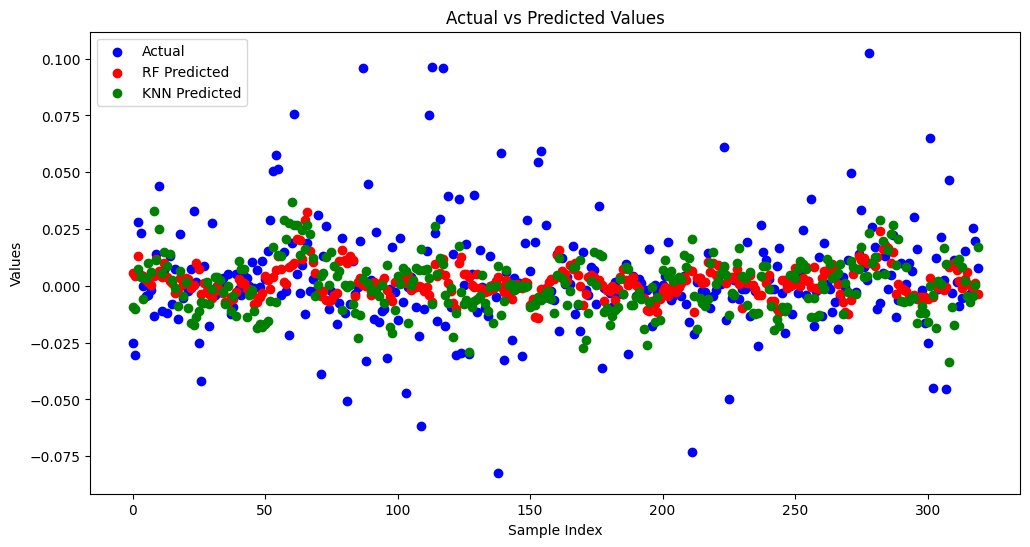

Random Forest Metrics:
Mean Absolute Error: 0.016078685397527756
Mean Absolute Percentage Error: 2.28387076868293
Mean Squared Error: 0.0005661225589662288
R2 Score: -0.05596368177415756

KNN Metrics:
Mean Absolute Error: 0.01839777751460678
Mean Absolute Percentage Error: 3.9727808258391732
Mean Squared Error: 0.0006530176704527441
R2 Score: -0.21804533776933965


In [52]:
#
predictions_RF = best_RF.predict(X_test)
predictions_KNN = best_KNN.predict(X_test)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue")
plt.scatter(
    range(len(predictions_RF)), predictions_RF, label="RF Predicted", color="red"
)
plt.scatter(
    range(len(predictions_KNN)), predictions_KNN, label="KNN Predicted", color="green"
)
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.show()


# Calculating error metrics for Random Forest
rf_mae = mean_absolute_error(y_test, predictions_RF)
rf_mape = mean_absolute_percentage_error(y_test, predictions_RF)
rf_mse = mean_squared_error(y_test, predictions_RF)
rf_r2 = r2_score(y_test, predictions_RF)

# Calculating error metrics for KNN
knn_mae = mean_absolute_error(y_test, predictions_KNN)
knn_mape = mean_absolute_percentage_error(y_test, predictions_KNN)
knn_mse = mean_squared_error(y_test, predictions_KNN)
knn_r2 = r2_score(y_test, predictions_KNN)

# Printing the errors for Random Forest
print("Random Forest Metrics:")
print("Mean Absolute Error:", rf_mae)
print("Mean Absolute Percentage Error:", rf_mape)
print("Mean Squared Error:", rf_mse)
print("R2 Score:", rf_r2)

# Printing the errors for KNN
print("\nKNN Metrics:")
print("Mean Absolute Error:", knn_mae)
print("Mean Absolute Percentage Error:", knn_mape)
print("Mean Squared Error:", knn_mse)
print("R2 Score:", knn_r2)